# Demand Forecasting of Retail Sales (Aggregated Daily)

## Notebook Overview

This notebook implements the full demand forecasting workflow used in the thesis.
The analysis is conducted at an **aggregated daily demand level**, consistent with the methodology described in the dissertation.

The notebook follows these main steps:
1. Data loading and preprocessing  
2. Daily aggregation of transactional data  
3. Exploratory data checks  
4. Model implementation (Naïve, SARIMA, CatBoost)  
5. Model evaluation and comparison  

All reported results in the thesis are generated from this notebook.


## Environment Setup

This notebook was executed in Google Colab.
All required libraries are imported below.
CatBoost is installed explicitly to ensure reproducibility.


In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from catboost import CatBoostRegressor

## Data Source

The dataset is stored on Google Drive and loaded into the notebook.
It contains transactional-level retail sales data across multiple stores and products.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

df = pd.read_csv('/content/drive/MyDrive/retail_store_inventory.csv')
df.head()



,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


## Exploratory Data Checks

Before carrying out the steps for aggregation and modeling, basic exploratory analysis tests were performed. Such tests include analysis of missing values, tests for ensuring correct data types, and analysis of temporal coverage of the dataset.


In [5]:
df.head()
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


### Data Quality Verification

- the absence of missing values,
- the absence of duplicate observations,
- the temporal coverage of the dataset.


In [6]:
#  Data quality checks
print("Shape:", df.shape)
print("Date range:", df["Date"].min(), "→", df["Date"].max())

# Missing values check
na_counts = df.isna().sum()
print("\nMissing values per column:\n", na_counts[na_counts > 0] if (na_counts > 0).any() else "No missing values.")

# Duplicate row check
print("\nDuplicate rows:", df.duplicated().sum())


Shape: (73100, 15)
Date range: 2022-01-01 → 2024-01-01

Missing values per column:
 No missing values.

Duplicate rows: 0


## Temporal Ordering

The dataset is sorted chronologically according to the Date variable.
This step is essential to preserve the temporal structure required
for forecasting and time-based train–test splitting.


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['Date'].dtype



dtype('<M8[ns]')

## Daily Aggregation of Transactional Data

For alignment with traditional time series benchmarks and to have a fixed forecasting target, the transaction-level data is aggregated on a daily basis. The target variable "Units Sold" is aggregated over all stores and all products for each day, and other variables are aggregated using suitable summary statistics.

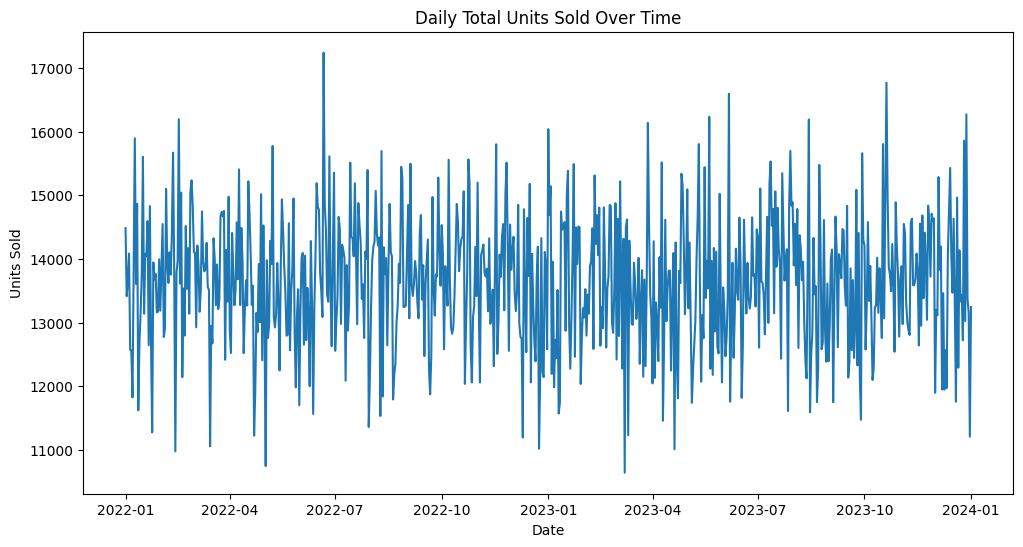

In [8]:
daily_sales = df.groupby("Date")["Units Sold"].sum()

plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales.values)
plt.title("Daily Total Units Sold Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()



## Exploratory Patterns in Aggregated Demand

Basic exploratory visualizations are used to inspect temporal patterns
in aggregated daily demand, including overall trends and day-of-week effects.


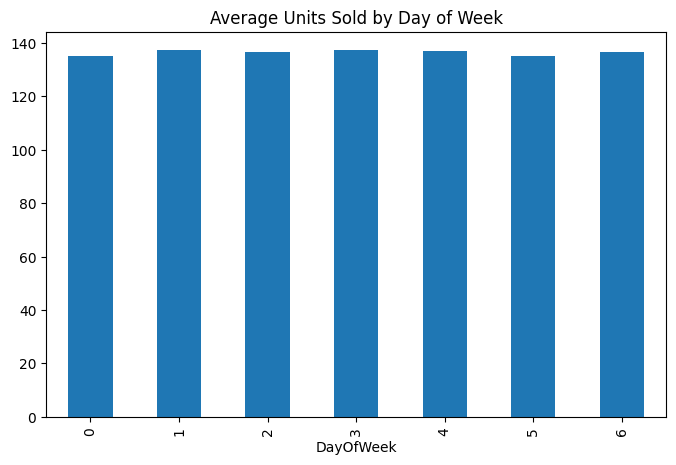

In [9]:
#weekly

df['DayOfWeek'] = df['Date'].dt.dayofweek

df.groupby("DayOfWeek")["Units Sold"].mean().plot(kind="bar", figsize=(8,5))
plt.title("Average Units Sold by Day of Week")
plt.show()


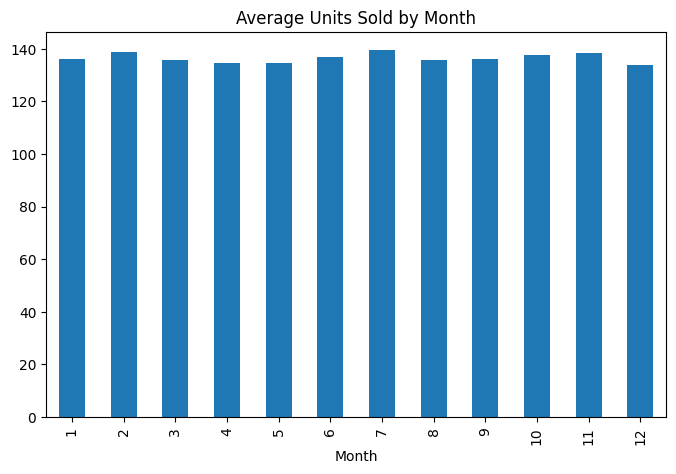

In [10]:
#monthly

df['Month'] = df['Date'].dt.month

df.groupby("Month")["Units Sold"].mean().plot(kind="bar", figsize=(8,5))
plt.title("Average Units Sold by Month")
plt.show()


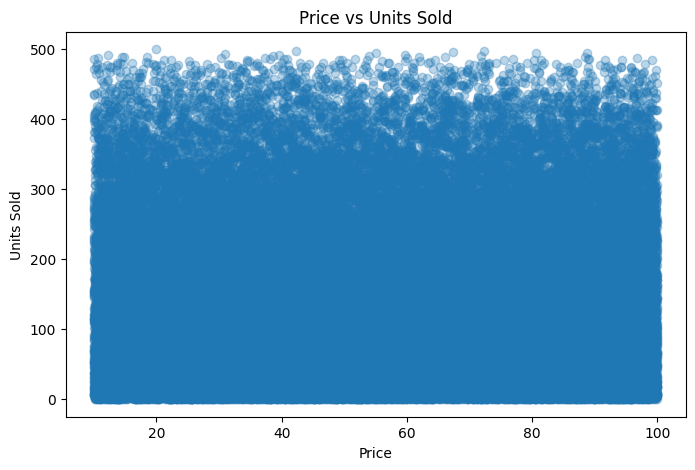

In [11]:
plt.figure(figsize=(8,5))
plt.scatter(df['Price'], df['Units Sold'], alpha=0.3)
plt.title("Price vs Units Sold")
plt.xlabel("Price")
plt.ylabel("Units Sold")
plt.show()


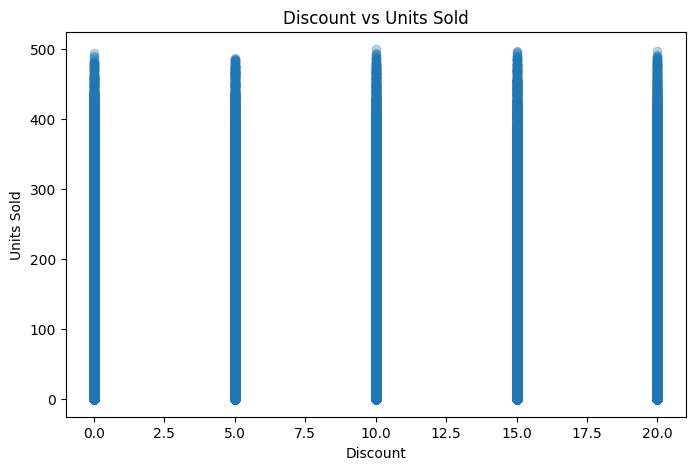

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(df['Discount'], df['Units Sold'], alpha=0.3)
plt.title("Discount vs Units Sold")
plt.xlabel("Discount")
plt.ylabel("Units Sold")
plt.show()


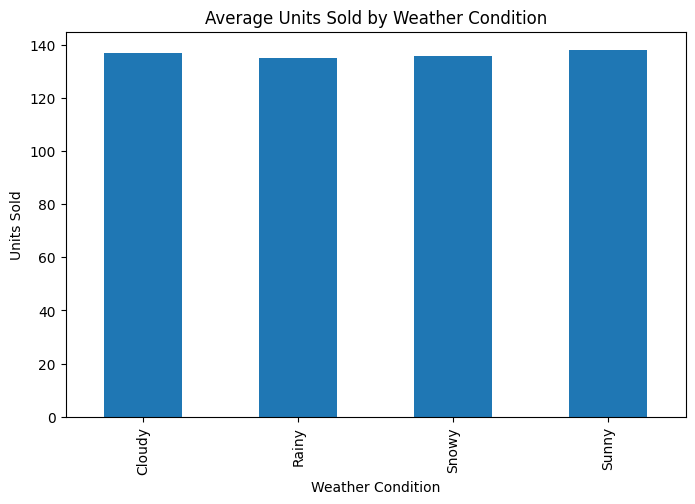

In [13]:
df.groupby("Weather Condition")["Units Sold"].mean().plot(
    kind="bar", figsize=(8,5)
)
plt.title("Average Units Sold by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Units Sold")
plt.show()


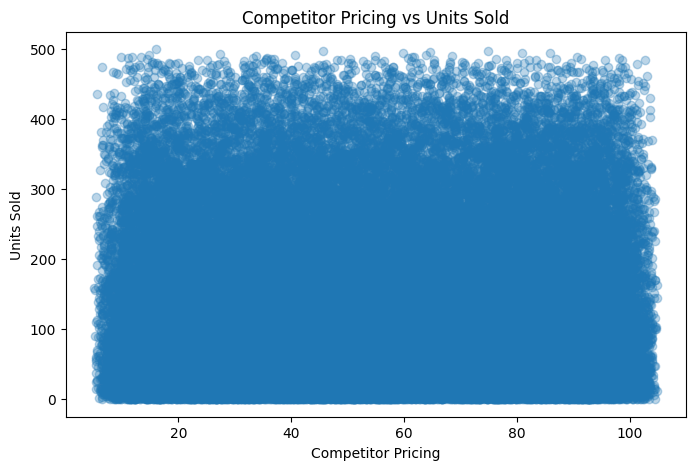

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(df['Competitor Pricing'], df['Units Sold'], alpha=0.3)
plt.title("Competitor Pricing vs Units Sold")
plt.xlabel("Competitor Pricing")
plt.ylabel("Units Sold")
plt.show()


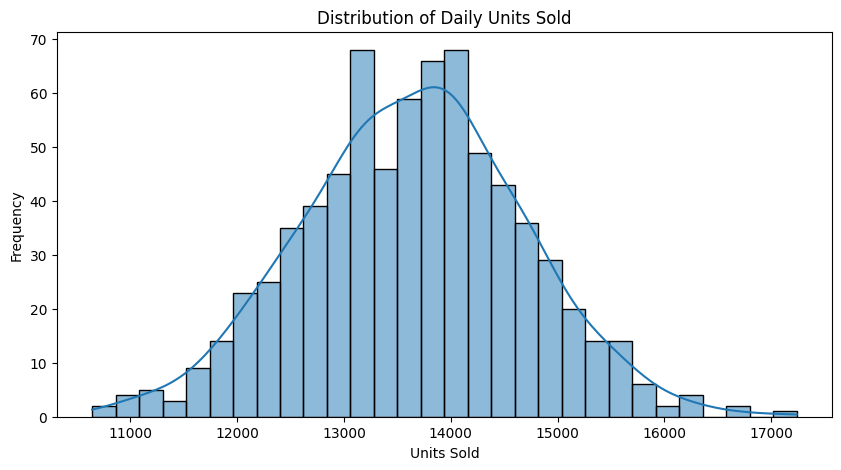

In [15]:


plt.figure(figsize=(10, 5))

sns.histplot(daily_sales, kde=True, bins=30)


plt.title("Distribution of Daily Units Sold")
plt.xlabel("Units Sold")
plt.ylabel("Frequency")
plt.show()



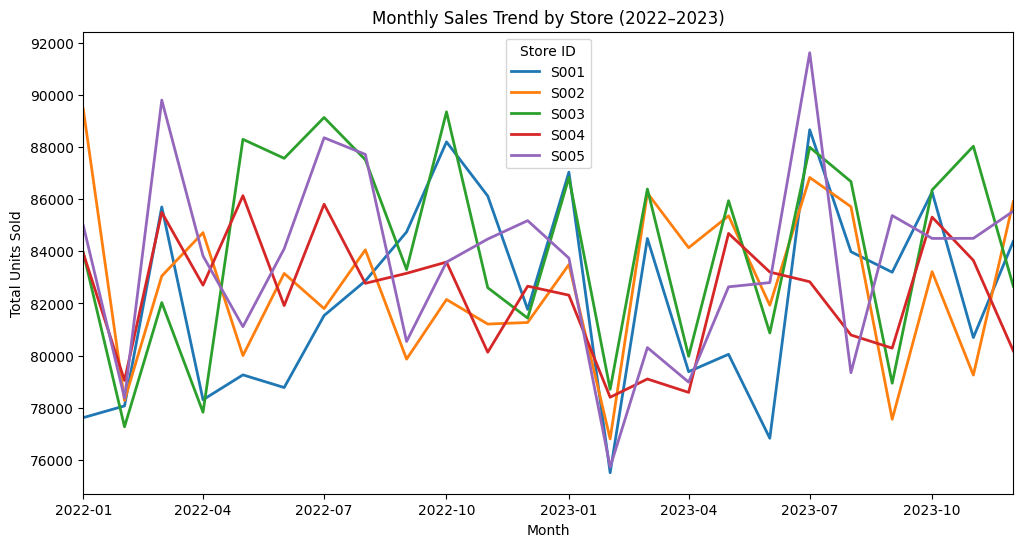

In [16]:

df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()

monthly_store_trend = df.groupby(['Month', 'Store ID'])['Units Sold'].sum().reset_index()
monthly_store_trend = monthly_store_trend[monthly_store_trend['Month'] < '2024-01-01']


plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_store_trend,
    x='Month',
    y='Units Sold',
    hue='Store ID',
    linewidth=2
)

plt.title("Monthly Sales Trend by Store (2022–2023)")
plt.xlim(monthly_store_trend['Month'].min(), monthly_store_trend['Month'].max())

plt.xlabel("Month")
plt.ylabel("Total Units Sold")
plt.show()




Correlation analysis is conducted on numeric variables to explore
linear relationships prior to model implementation.


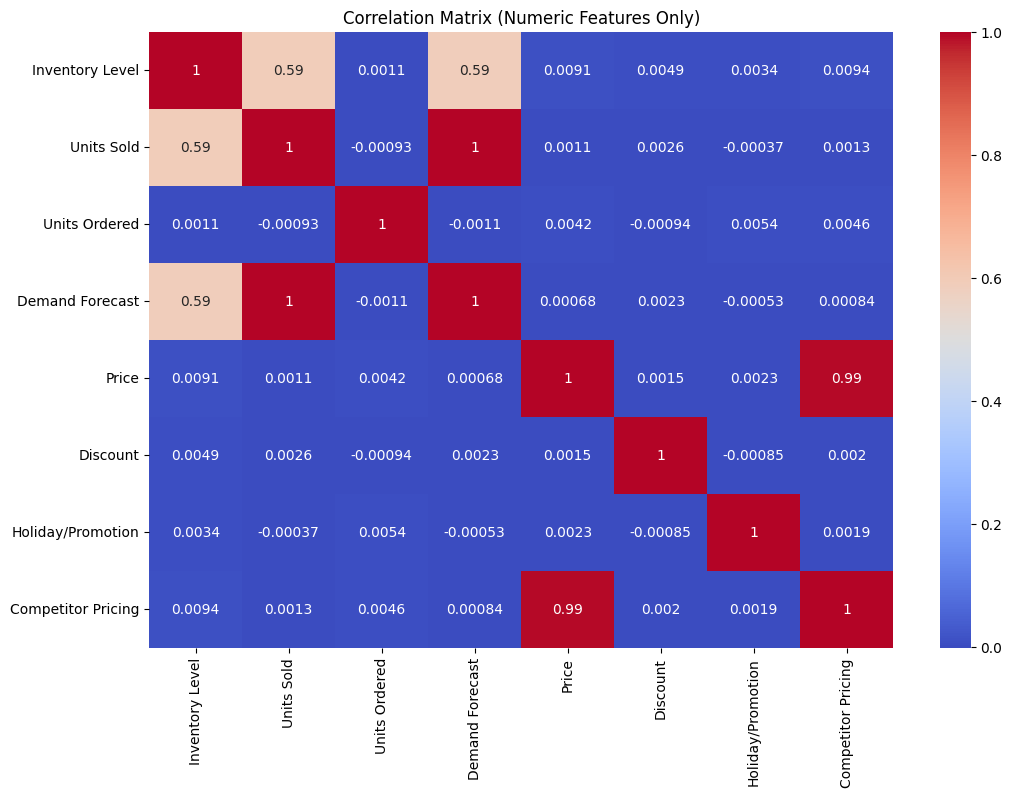

In [17]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()




## Baseline Forecasting Setup

To create a basis for comparison among models, a transactional sales data is first compiled into a unified daily demand series.
This is a daily series indicating total sales of units in all stores.
and products for each date and serves as an input for all forecasting
models tested in this study.

In [18]:


daily_sales = df.groupby('Date')['Units Sold'].sum().to_frame(name='Units_Sold')

daily_sales.head()


,Units_Sold
Date,
2022-01-01,14484
2022-01-02,13415
2022-01-03,13681
2022-01-04,14084
2022-01-05,12572


## Train–Test Split Strategy

A time-ordered train–test split is applied to the aggregated daily
demand series. The first 80% of observations are used for model training,
while the remaining 20% are reserved for out-of-sample evaluation.
This approach preserves the temporal structure of the data and prevents
information leakage.


In [19]:

n = len(daily_sales)
train_size = int(n * 0.8)

train = daily_sales.iloc[:train_size]
test = daily_sales.iloc[train_size:]

print(len(train), len(test))

y_train = train['Units_Sold']
y_test = test['Units_Sold']



584 147


## Naïve Benchmark Model

As a basic benchmark, a naïve forecasting model is established.
This technique presumes a fixed demand level for a given day equal to
observed demand of the previous day. Although it is simple, the naive
model serves as a good lower bound for comparing more
advanced forecasting methods.

In [20]:

y_pred_naive = y_test.shift(1)


valid_idx = ~y_pred_naive.isna()
y_true = y_test[valid_idx]
y_pred = y_pred_naive[valid_idx]



mae_naive = mean_absolute_error(y_true, y_pred)
rmse_naive = mean_squared_error(y_true, y_pred) ** 0.5


mape_naive = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Naive MAE:", mae_naive)
print("Naive RMSE:", rmse_naive)
print("Naive MAPE (%):", mape_naive)


Naive MAE: 1181.890410958904
Naive RMSE: 1488.458778148248
Naive MAPE (%): 8.70569425980536


## Seasonal ARIMA (SARIMA) Model

To model temporal dependencies and seasonal trends in the series of demand on a daily basis, a Seasonal ARIMA model is used. In this model, both non-seasonal and seasonal series are considered, which include a weekly seasonality.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    y_train,
    order=(1, 1, 1),          # p, d, q
    seasonal_order=(1, 1, 1, 7)  # P, D, Q, s
)

sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                        Units_Sold   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4858.394
Date:                           Tue, 16 Dec 2025   AIC                           9726.789
Time:                                   23:09:20   BIC                           9748.569
Sample:                               01-01-2022   HQIC                          9735.283
                                    - 08-07-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0410      0.039      1.059      0.290      -0.035       0.117
ma.L1         -0.9773      0.015    -67.168

Following model estimation, out-of-sample forecasts are generated for
the test period using the fitted SARIMA model.


In [22]:
sarima_pred = sarima_result.forecast(steps=len(y_test))
sarima_pred = pd.Series(sarima_pred.values, index=y_test.index)


The SARIMA model results provide a classical statistical benchmark for
comparison with both the naïve approach and the machine learning-based
CatBoost model.


In [23]:

mae_sarima = mean_absolute_error(y_test, sarima_pred)
rmse_sarima = mean_squared_error(y_test, sarima_pred) ** 0.5
mape_sarima = np.mean(np.abs((y_test - sarima_pred) / y_test)) * 100

print("SARIMA MAE:", mae_sarima)
print("SARIMA RMSE:", rmse_sarima)
print("SARIMA MAPE (%):", mape_sarima)


SARIMA MAE: 907.3301982763388
SARIMA RMSE: 1119.8806779508934
SARIMA MAPE (%): 6.8837420104408995


In [24]:
df['Store ID'].nunique(), df['Product ID'].nunique()


(5, 20)

In [25]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")


## Forecasting Target Series (Aggregated Daily Demand)
To ensure consistency between statistical time series models and machine learning approaches,the transactional retail dataset was aggregated at a daily level.This aggregation results in a single observation per day and forms the target time series used throughout the forecasting analysis.

In [26]:
df_daily = (
    df.groupby("Date")
    .agg({
        "Units Sold": "sum",
        "Inventory Level": "mean",
        "Price": "mean",
        "Discount": "mean",
        "Competitor Pricing": "mean",
        "Holiday/Promotion": "max",
        "Weather Condition": lambda x: x.mode().iloc[0],
        "Seasonality": lambda x: x.mode().iloc[0]
    })
    .reset_index()
    .sort_values("Date")
)



### Validation Check: Daily Aggregation Consistency

To check if the aggregation procedure is done in the right manner, the number of rows in the aggregated daily data set was compared to the number of distinct dates in the original data set.
A one-to-one correspondence verifies that each day of the calendar is accounted for exactly in the aggregated dataset.

In [27]:
print("Daily rows:", df_daily.shape[0])
print("Unique dates in raw:", df["Date"].nunique())
df_daily.head()


Daily rows: 731
Unique dates in raw: 731


,Date,Units Sold,Inventory Level,Price,Discount,Competitor Pricing,Holiday/Promotion,Weather Condition,Seasonality
0,2022-01-01,14484,284.24,57.5157,10.65,58.1831,1,Cloudy,Spring
1,2022-01-02,13415,272.50,60.6365,9.80,60.2371,1,Cloudy,Spring
2,2022-01-03,13681,272.69,56.7993,8.85,56.8813,1,Cloudy,Winter
3,2022-01-04,14084,275.88,52.9930,10.60,52.8153,1,Sunny,Summer
4,2022-01-05,12572,286.80,55.9958,10.40,56.0426,1,Rainy,Spring


# Calendar Feature Engineering
Feature engineering is

To incorporate short-term and seasonal variation in temporal demand, these features were obtained from the Date variable.

This variables include:
- Day of week (0 = Monday, 6 = Sunday)
- month of the year
 - Weekend indicator
Such variables enable machine learning algorithms to include systematic temporal effects which cannot otherwise be modelled with a univariate time series model.

In [28]:
df_daily["day_of_week"] = df_daily["Date"].dt.dayofweek
df_daily["month"] = df_daily["Date"].dt.month
df_daily["is_weekend"] = (df_daily["day_of_week"] >= 5).astype(int)


In [29]:
target_col = "Units Sold"

feature_cols = [
    "Inventory Level",
    "Price",
    "Discount",
    "Competitor Pricing",
    "Holiday/Promotion",
    "Weather Condition",
    "Seasonality",
    "day_of_week",
    "month",
    "is_weekend"
]

X = df_daily[feature_cols]
y = df_daily[target_col]



## Time-conscious Train-Test Split

As demand forecasting is a time-dependent forecasting problem in essence, a time-split train-test split technique was used rather than random sampling.

The first 80% of observations were used for model training,
A 20% share remained in reserve to be tested.
Such a model prevents information leakage and ensures realistic
out-of-sample evaluation

In [30]:
split_idx = int(len(df_daily) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", len(y_train), "Test size:", len(y_test))
print("Train last date:", df_daily.iloc[split_idx-1]["Date"])
print("Test first date:", df_daily.iloc[split_idx]["Date"])


Train size: 584 Test size: 147
Train last date: 2023-08-07 00:00:00
Test first date: 2023-08-08 00:00:00


## Machine Learning Model: CatBoost Regression Model

CatBoost is chosen because it can support categorical variables and can be used in model building without having to encode them manually using one-hot encoding. Although this model takes a variety of aggregates of daily inputs, not all of them are classified either as categorical or numeric, with only two being considered categorical variables.


In [31]:
cat_features = ["Weather Condition", "Seasonality"]

model_cb = CatBoostRegressor(
    iterations=300,
    depth=8,
    learning_rate=0.1,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

model_cb.fit(X_train, y_train, cat_features=cat_features)
y_pred_cat = model_cb.predict(X_test)


## Model Evaluation Metrics

Model performance was evaluated using three complementary error metrics:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Percentage Error (MAPE)

Using multiple metrics allows for a balanced assessment of absolute,
variance-sensitive, and relative forecasting accuracy.


In [32]:
mae_cat = mean_absolute_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
mape_cat = np.mean(np.abs((y_test - y_pred_cat) / y_test)) * 100

print("CatBoost MAE:", mae_cat)
print("CatBoost RMSE:", rmse_cat)
print("CatBoost MAPE (%):", mape_cat)


CatBoost MAE: 727.1213279522777
CatBoost RMSE: 890.5222237359459
CatBoost MAPE (%): 5.425062329900108


The purpose of this step is to record in detail all the final features used during model implementation for an accurate forecast output.

In [33]:
df_daily.columns
df_daily.head()


,Date,Units Sold,Inventory Level,Price,Discount,Competitor Pricing,Holiday/Promotion,Weather Condition,Seasonality,day_of_week,month,is_weekend
0,2022-01-01,14484,284.24,57.5157,10.65,58.1831,1,Cloudy,Spring,5,1,1
1,2022-01-02,13415,272.50,60.6365,9.80,60.2371,1,Cloudy,Spring,6,1,1
2,2022-01-03,13681,272.69,56.7993,8.85,56.8813,1,Cloudy,Winter,0,1,0
3,2022-01-04,14084,275.88,52.9930,10.60,52.8153,1,Sunny,Summer,1,1,0
4,2022-01-05,12572,286.80,55.9958,10.40,56.0426,1,Rainy,Spring,2,1,0


## Comparative Model Performance

To enable direct comparison among different forecasting methods, all evaluation metrics were collected into a single summary table.

In [34]:


results_df = pd.DataFrame({
    "Model": ["Naive", "CatBoost", "SARIMA"],
    "MAE": [mae_naive, mae_cat, mae_sarima],
    "RMSE": [rmse_naive, rmse_cat, rmse_sarima],
    "MAPE (%)": [mape_naive, mape_cat, mape_sarima]
})

results_df


,Model,MAE,RMSE,MAPE (%)
0,Naive,1181.890411,1488.458778,8.705694
1,CatBoost,727.121328,890.522224,5.425062
2,SARIMA,907.330198,1119.880678,6.883742


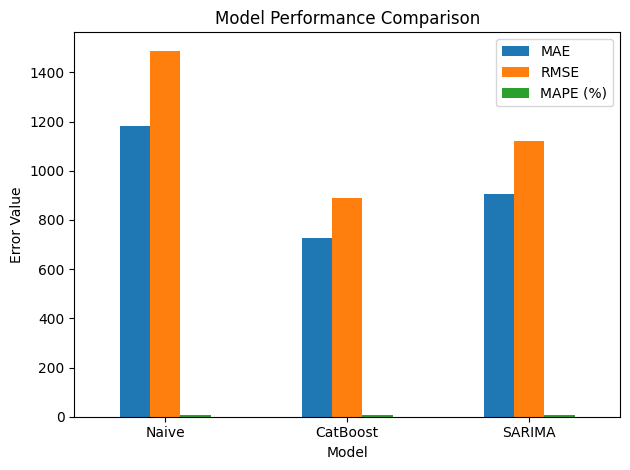

In [35]:
results_df.set_index("Model")[["MAE", "RMSE", "MAPE (%)"]].plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Error Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
